<a href="https://colab.research.google.com/github/anirbanpranto/tapway-intern-assessment/blob/main/04_pytorch_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Set Arguements

In [3]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=20  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True

# Load data (MNIST)

In [4]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Original Model
The original given model has a dropout layer in FC1 but not in FC2

In [5]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)


# Answers to Tapway Assessment

# 1. a) Early Stopper

In [6]:
import numpy as np

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.count = 0
        self.min = np.inf

    def __call__(self, loss):
        if loss < self.min:
            self.min = loss
            self.count = 0
        elif loss > (self.min + self.min_delta):
            self.count += 1
            if self.count >= self.patience:
                return True
        return False

# Training with early stop
Since there is no validation data I'll use the early stopper for test dataset loss.

In [7]:
class Trainer():
  def __init__(self, model, train_loader, test_loader, optimizer):
    self.train_loss_data = []
    self.test_loss_data = []
    self.train_data = []
    self.test_data = []
    self.model = model
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.optimizer = optimizer

  def get_data(self):
    return self.train_loss_data, self.test_loss_data, self.train_data, self.test_data

  def train(self, epoch):
      self.model.train()
      correct = 0
      train_loss = 0
      for batch_idx, (data, target) in enumerate(self.train_loader):
          if args['cuda']:
              data, target = data.cuda(), target.cuda()
          #Variables in Pytorch are differenciable. 
          data, target = Variable(data), Variable(target)
          #This will zero out the gradients for this batch. 
          self.optimizer.zero_grad()
          output = self.model(data)
          train_loss += F.nll_loss(output, target, reduction='sum').data # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
          # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
          loss = F.nll_loss(output, target)
          #dloss/dx for every Variable 
          loss.backward()
          #to do a one-step update on our parameter.
          self.optimizer.step()
          #Print out the loss periodically. 
          if batch_idx % args['log_interval'] == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(self.train_loader.dataset),
                  100. * batch_idx / len(self.train_loader), loss.data))
      train_loss /= len(self.train_loader.dataset)
      self.train_loss_data.append(train_loss.data)
      tr_loss = 1. - (correct / len(self.train_loader.dataset))
      self.train_data.append(tr_loss)

      print("Summary Epoch : ")
      print('Train set: Average loss (NLL): {:.4f}, Accuracy: {}/{} ({:.0f}%), Loss: ({:.0f}%)'.format(train_loss, correct, len(self.train_loader.dataset), 100. * correct / len(self.train_loader.dataset), 100. * tr_loss))

  def test(self):
      self.model.eval()
      test_loss = 0
      correct = 0
      for data, target in self.test_loader:
          if args['cuda']:
              data, target = data.cuda(), target.cuda()
          with torch.no_grad(): #no need to use autograd in test
            data, target = Variable(data), Variable(target)
            output = self.model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').data # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
      ts_loss = 1. - (correct / len(self.test_loader.dataset))
      test_loss /= len(self.test_loader.dataset)
      self.test_data.append(ts_loss)
      print('Test set: Average loss (NLL): {:.4f}, Accuracy: {}/{} ({:.0f}%), Loss: ({:.0f}%)\n'.format(
          test_loss, correct, len(self.test_loader.dataset),
          100. * correct / len(self.test_loader.dataset), 100. * ts_loss))
      self.test_loss_data.append(test_loss.data)
      return test_loss

In [8]:
model = Net()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  #We'll stop training after no improvement in 5 epochs
early_stopper = EarlyStopper(5)

args['epochs'] = 200
trainer = Trainer(model, train_loader, test_loader, optimizer)
for epoch in range(1, args['epochs'] + 1):
    trainer.train(epoch)
    loss = trainer.test()
    if(early_stopper(loss.item())):
      print('Stopping here at epoch {}/{}'.format(epoch, args['epochs']))
      break
    print("--------------------------------------------------------------")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312986
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.296214
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.294844
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.274916
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.266913
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.248727
Summary Epoch : 
Train set: Average loss (NLL): 2.2765, Accuracy: 8853/60000 (15%), Loss: (85%)
Test set: Average loss (NLL): 2.2101, Accuracy: 3267/10000 (33%), Loss: (67%)

--------------------------------------------------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.232357
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.198167
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.179638
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.104615
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.044308
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.979951
Summary Epoch : 
Train set: Average loss (NLL): 2.1053, Accuracy: 16951/60000 (28%), Loss: (72%)
Test set: Average loss (NLL): 1.7343, Accuracy: 6848/10000 (68%), Loss: (32

In [9]:
train_loss, test_loss, train_acc_loss, test_acc_loss = trainer.get_data()

In [10]:
def plot_loss(test, train, plotname):
  import pandas as pd
  import matplotlib.pyplot as plt
  test = [x.item() for x in test]
  train = [x.item() for x in train]
  epochs = [x for x in range(1, len(train)+1)]
  plt.plot(epochs, test, label="Test")
  plt.plot(epochs, train, label="Train")
  plt.title(plotname)
  plt.legend(loc='upper center')
  plt.show()

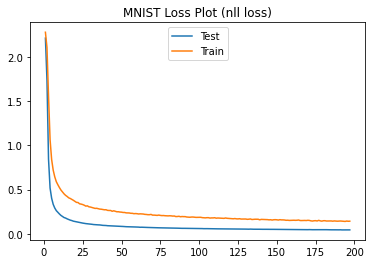

In [11]:
plot_loss(test_loss, train_loss, "MNIST Loss Plot (nll loss)")

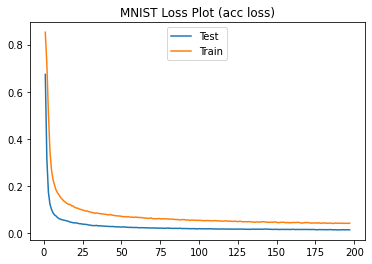

In [12]:
plot_loss(test_acc_loss, train_acc_loss, "MNIST Loss Plot (acc loss)")

# 1. b) Adding Dropout to Final FC2 layer

In [ ]:
class Net_Dropout_Fc2(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net_Dropout_Fc2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)

# Training with Dropout Layer

In [ ]:
model = Net_Dropout_Fc2()
if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

  #We'll stop training after no improvement in 5 epochs
early_stopper = EarlyStopper(5)

args['epochs'] = 200
trainer_do = Trainer(model, train_loader, test_loader, optimizer)
for epoch in range(1, args['epochs'] + 1):
    trainer_do.train(epoch)
    loss = trainer_do.test()
    if(early_stopper(loss.item())):
      print('Stopping here at epoch {}/{}'.format(epoch, args['epochs']))
      break
    print("--------------------------------------------------------------")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307931
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.302459
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.304956
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.301746
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.299095
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.294465
Summary Epoch : 
Train Epoch: 1, Loss: 2.289187

Test set: Average loss: 2.2859, Accuracy: 2397/10000 (24%)

Current Min :  2.2859103679656982
Current Count :  0
--------------------------------------------------------------
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.287210
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.292811
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.291663
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.288281
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.278299
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.276496
Summary Epoch : 
Train Epoch: 2, Loss: 2.272588

Test set: Average loss: 2.2479, Accuracy: 4133/10000 (41%)

Current Min :  2.247879981994629
Current Count :  0
------------------------

In [ ]:
train_loss_do, test_loss_do, train_acc_loss_do, test_acc_loss_do = trainer_do.get_data()

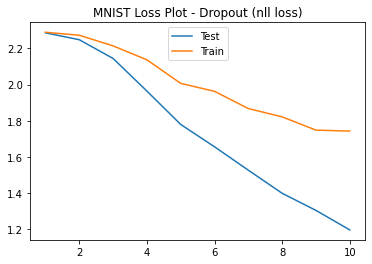

In [ ]:
plot_loss(test_loss_do, train_loss_do, "MNIST Loss Plot - Dropout (nll loss)")

In [ ]:
plot_loss(test_loss_do, train_loss_do, "MNIST Loss Plot - Dropout (acc loss)")